In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [2]:
def norm_phi1(x):
    # Function to calculate the module of a vector phi1
    return np.sqrt(x[0]**2 + x[1]**2)

def norm_phi2(x):
    # Function to calculate the module of a vector phi2
    return np.sqrt(x[2]**2 + x[3]**2)

def B(x):
    '''x is the norm of the 2D vector.
    B returns I1(x) / (I0(x) * x) where I0 and I1 are the modified Bessel functions of the first kind.'''
    return i1(x) / (i0(x) * x)

def DiffE_phi(phi, om, T, J12, J1, J2):
    coeff1 = T / J12
    coeff2 = 1 / J12
    return [coeff1 * phi[2] - B(norm_phi1(phi)) * phi[0] - coeff2 * J2 * om[2],
            coeff1 * phi[3] - B(norm_phi1(phi)) * phi[1] - coeff2 * J2 * om[3],
            coeff1 * phi[0] - B(norm_phi2(phi)) * phi[2] - coeff2 * J1 * om[0],
            coeff1 * phi[1] - B(norm_phi2(phi)) * phi[3] - coeff2 * J1 * om[1]]

def DiffE_phi_alignament(phi, T, J12):
    '''phi = [phi1_x, phi1_y, phi2_x, phi2_y].'''
    coeff = T / J12
    return [coeff * phi[2] - B(norm_phi1(phi)) * phi[0],
            coeff * phi[3] - B(norm_phi1(phi)) * phi[1],
            coeff * phi[0] - B(norm_phi2(phi)) * phi[2],
            coeff * phi[1] - B(norm_phi2(phi)) * phi[3]]

# def DiffE_s_alignament(s, J12):
#     '''s = [s1_x, s1_y, s2_x, s2_y]'''
#     return [J12 * s[2],
#             J12 * s[3],
#             J12 * s[0],
#             J12 * s[1]]

def DiffE_s_alignament(s, J12):
    '''s = [s1_x, s2_x]'''
    return [-J12 * (s[1] - s[0]/np.sqrt(1-s[0]**2)),
            -J12 * (s[0] - s[1]/np.sqrt(1-s[1]**2))]

def check_constraint_comp(phi, om, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is in N(om2, theta0).'''
    phi1 = [phi[0], phi[1]]
    phi2 = [phi[2], phi[3]]
    phi1 = phi1 / np.linalg.norm(phi1)
    phi2 = phi2 / np.linalg.norm(phi2)
    return np.arccos(round(np.dot(phi1, [om[0], om[1]]),5)) <= theta0 and np.arccos(round(np.dot(phi2, [om[2], om[3]]),5)) <= theta0

def check_constraint_dec(phi, om, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is not in N(om2, theta0).'''
    phi1 = phi[0:2]
    phi2 = phi[2:4]
    phi1 = phi1 / np.linalg.norm(phi1)
    phi2 = phi2 / np.linalg.norm(phi2)
    return np.arccos(round(np.dot(phi1, [om[0], om[1]]),5)) < theta0 and np.arccos(round(np.dot(phi2, [om[2], om[3]]),5)) > theta0

def is_stable(phi, om, T, J12, J1, J2):
    jac_matrix = root(DiffE_phi, phi, args=(om, T, J12, J1, J2)).fjac
    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues, _ = np.linalg.eig(jac_matrix)
    # Check stability
    if all(eigenvalues.real < 0):
        return True
    else:
        return False

## Check only alignament case, to warm up

In [3]:
J12 = 1
T = 10

# generate random unit vectors
phi1_i = np.random.rand(2)
phi2_i = np.random.rand(2)
print('phi1_i =', phi1_i)
print('phi2_i =', phi2_i)

phi_sol = fsolve(DiffE_phi_alignament, [phi1_i, phi2_i], args=(T, J12))
phi_sol_0 = fsolve(DiffE_phi_alignament, [[0.1,0.1], [0.1,0.1]], args=(T, J12))

print('phi_sol =', np.around(phi_sol, 5))
print('phi_sol_0 =', np.around(phi_sol_0, 5))

#check that phi_sol is a solution of the equation
print('DiffE_phi_alignament(phi_sol) =', np.around(DiffE_phi_alignament(phi_sol, T, J12),5))
print('DiffE_phi_alignament(phi_sol_0) =', np.around(DiffE_phi_alignament(phi_sol_0, T, J12),5))

phi1_i = [0.58335078 0.68012882]
phi2_i = [0.25886515 0.19229312]
phi_sol = [-0.  0. -0.  0.]
phi_sol_0 = [-0.  0. -0.  0.]
DiffE_phi_alignament(phi_sol) = [-0.  0.  0.  0.]
DiffE_phi_alignament(phi_sol_0) = [-0.  0. -0.  0.]


## Now add external field (i.e. targets)

In [4]:
# COMPROMISE

J12 = 100
Jmax = 10
J1 = Jmax
J2 = Jmax
T = 50
om1 = np.radians(40)
om2 = np.radians(0)
theta0 = np.radians(20)

# generate random unit vectors for initial conditions
# phi1_i = np.random.rand(2)
# phi2_i = np.random.rand(2)
phi1_i = [np.cos(om1), np.sin(om1)]
phi2_i = [np.cos(om2), np.sin(om2)]
om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
# print('phi1_i =', phi1_i)
# print('phi2_i =', phi2_i)

phi_sol = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, J1, J2))
# phi_sol_0 = fsolve(DiffE_phi, [[0,0], [0,0]], args=(om, T, J12, J1, J2))

print('phi_sol =', np.around(phi_sol, 5))
# print('phi_sol_0 =', np.around(phi_sol_0, 5))

#check that phi_sol is a solution of the equation
print('DiffE_phi(phi_sol) =', np.around(DiffE_phi(phi_sol, om, T, J12, J1, J2),5))
# print('DiffE_phi(phi_sol_0) =', np.around(DiffE_phi(phi_sol_0, om, T, J12, J1, J2),5))

#check that phi_sol satisfies the constraint
print('check_constraint(phi_sol) =', check_constraint_comp(phi_sol, om, theta0))

# calculate angle between phi1 and x axis and phi2 and x axis
phi1 = phi_sol[0:2]
phi2 = phi_sol[2:4]

phi1 = phi1 / np.linalg.norm(phi1)
phi2 = phi2 / np.linalg.norm(phi2)

print('phi1 =', phi1)
print('phi2 =', phi2)

print('angle between phi1 and x axis =', np.degrees(np.arccos(np.dot(phi1, [1, 0]))))
print('angle between phi2 and x axis =', np.degrees(np.arccos(np.dot(phi2, [1, 0]))))



phi_sol = [1.14734 0.45699 1.17266 0.38742]
DiffE_phi(phi_sol) = [ 0. -0.  0.  0.]
check_constraint(phi_sol) = True
phi1 = [0.92901805 0.3700344 ]
phi2 = [0.94952265 0.3136985 ]
angle between phi1 and x axis = 21.717738934805553
angle between phi2 and x axis = 18.28226106535515


In [5]:
# DECISION

J12 = 10
J1 = 100
J2 = 0
T = 0.2
om1 = np.radians(5)
om2 = np.radians(-5)
theta0 = np.radians(20)

# generate random unit vectors
# generate random unit vectors for initial conditions
# phi1_i = np.random.rand(2)
# phi2_i = np.random.rand(2)
phi1_i = [np.cos(om1), np.sin(om1)]
phi2_i = [np.cos(om2), np.sin(om2)]
om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
# print('phi1_i =', phi1_i)
# print('phi2_i =', phi2_i)

phi_sol = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, J1, J2), maxfev=100000)
# phi_sol_0 = fsolve(DiffE_phi, [[0.1,0.1], [0.1,0.1]], args=(om, T, J12, J1, J2))

print('phi_sol =', np.around(phi_sol, 5))
# print('phi_sol_0 =', np.around(phi_sol_0, 5))

#check that phi_sol is a solution of the equation
print('DiffE_phi(phi_sol) =', np.around(DiffE_phi(phi_sol, om, T, J12, J1, J2),5))
# print('DiffE_phi(phi_sol_0) =', np.around(DiffE_phi(phi_sol_0, om, T, J12, J1, J2),5))

#check that phi_sol satisfies the constraint
print('check_constraint(phi_sol) =', check_constraint_dec(phi_sol, om, theta0))

# calculate angle between phi1 and x axis and phi2 and x axis
phi1 = phi_sol[0:2]
phi2 = phi_sol[2:4]

phi1 = phi1 / np.linalg.norm(phi1)
phi2 = phi2 / np.linalg.norm(phi2)

print('phi1 =', phi1)
print('phi2 =', phi2)

print('angle between phi1 and x axis =', np.degrees(np.arccos(np.dot(phi1, [1, 0]))))
print('angle between phi2 and x axis =', np.degrees(np.arccos(np.dot(phi2, [1, 0]))))



phi_sol = [547.40599  47.89182  49.76439   4.35382]
DiffE_phi(phi_sol) = [ 0. -0. -0. -0.]
check_constraint(phi_sol) = False
phi1 = [0.9961947  0.08715574]
phi2 = [0.9961947  0.08715574]
angle between phi1 and x axis = 4.999999998551302
angle between phi2 and x axis = 4.999999998294319


## STRUCTURED ANALYSIS
All the parameters influence the solutions: $J_{max}, J_{12}, T$

In [14]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi1', 'phi2'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi1', 'phi2'])

# solve the equation for different values of J12, Jmax and T

# om1 = np.radians(50)
# om2 = np.radians(-50)
theta0 = np.radians(20)

T = 10
#J12 = 10
Jmax = 10
om2 = 0

for om1 in np.arange(0, np.pi, np.pi/60):
    for J12 in np.arange(1, 100, 1):
        phi1_i = [np.cos(om1), np.sin(om1)]
        phi2_i = [np.cos(om2), np.sin(om2)]
        om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
        phi_comp = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, Jmax, Jmax))
        phi_dec = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, Jmax, 0))

        # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'T': T, 'om': om, 'theta0': theta0, 'phi1': phi_comp[0:2], 'phi2': phi_comp[2:4]}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'T': T, 'om': om, 'theta0': theta0, 'phi1': phi_dec[0:2], 'phi2': phi_dec[2:4]}, ignore_index=True)

In [15]:
# add a row with the check of the constraint
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['theta0']), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['theta0']), axis=1)

df_comp['is_stable'] = df_comp.apply(lambda row: is_stable([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)
df_dec['is_stable'] = df_dec.apply(lambda row: is_stable([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)

# from column om = [om1x, om1y, om2x, om2y] extract the values of om1 and om2
df_comp['om1'] = df_comp.apply(lambda row: np.arctan2(row['om'][1], row['om'][0]), axis=1)
df_comp['om2'] = df_comp.apply(lambda row: np.arctan2(row['om'][3], row['om'][2]), axis=1)
df_dec['om1'] = df_dec.apply(lambda row: np.arctan2(row['om'][1], row['om'][0]), axis=1)
df_dec['om2'] = df_dec.apply(lambda row: np.arctan2(row['om'][3], row['om'][2]), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om1'] - row['om2'], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om1'] - row['om2'], axis=1)

df_comp[df_comp['is_stable'] == False]

,J12,J1,J2,T,om,theta0,phi1,phi2,is_sol,is_stable,om1,om2,omega_diff
136,38,10,10,10,"[0.9986295347545739, 0.05233595624294383, 1.0,...",0.349066,"[-1.4196908468701506, -0.026157634244682624]","[-1.419151567191338, -0.04659922504745068]",False,False,0.052360,0.0,0.052360
137,39,10,10,10,"[0.9986295347545739, 0.05233595624294383, 1.0,...",0.349066,"[-1.4525586200128262, -0.02775961907865581]","[-1.4520051849915627, -0.04812232069379081]",False,False,0.052360,0.0,0.052360
138,40,10,10,10,"[0.9986295347545739, 0.05233595624294383, 1.0,...",0.349066,"[-1.4863983805902672, -0.02921330233483839]","[-1.485895534773282, -0.04861291799845042]",False,False,0.052360,0.0,0.052360
139,41,10,10,10,"[0.9986295347545739, 0.05233595624294383, 1.0,...",0.349066,"[-1.5169968115264012, -0.029777669287917023]","[-1.5164758591869523, -0.04966760893814127]",False,False,0.052360,0.0,0.052360
235,38,10,10,10,"[0.9945218953682733, 0.10452846326765347, 1.0,...",0.349066,"[-1.4192849467192858, -0.05452619840056993]","[-1.4171604637598911, -0.09523112047407449]",False,False,0.104720,0.0,0.104720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909,39,10,10,10,"[0.052335956242943966, 0.9986295347545739, 1.0...",0.349066,"[-1.6097765444655436, -1.1277435660511748]","[-1.2104472274142408, -1.548548863723105]",False,False,1.518436,0.0,1.518436
2970,1,10,10,10,"[6.123233995736766e-17, 1.0, 1.0, 0.0]",0.349066,"[6.123233995736766e-17, 1.0]","[1.0, 0.0]",True,False,1.570796,0.0,1.570796
3106,38,10,10,10,"[-0.05233595624294362, 0.998629534754574, 1.0,...",0.349066,"[-1.4870811696388702, -1.1232527433996458]","[-1.0438855495336739, -1.5438296829944504]",False,False,1.623156,0.0,1.623156
3303,37,10,10,10,"[-0.1564344650402308, 0.9876883405951377, 1.0,...",0.349066,"[-1.3671310042724083, -1.1077879762501994]","[-0.8802828607017983, -1.5235955724255705]",False,False,1.727876,0.0,1.727876


In [16]:
comp = df_comp[(df_comp['is_sol'] == True) & (df_comp['is_stable'] == True)]
dec = df_dec[(df_dec['is_sol'] == True) & (df_dec['is_stable'] == True)]

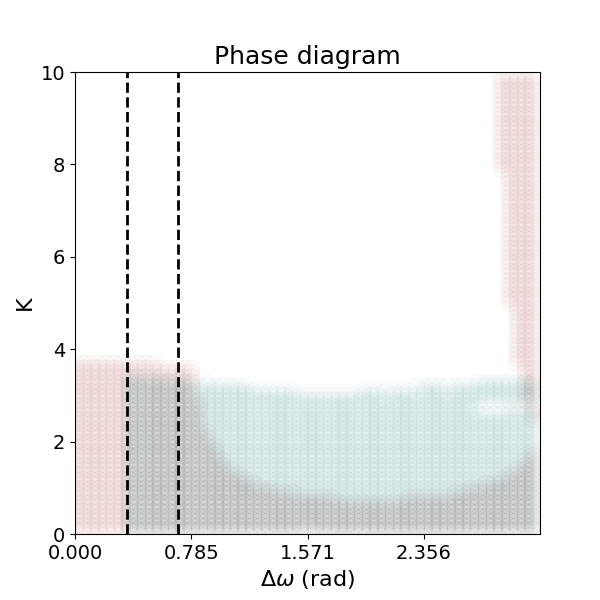

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Phase diagram', fontsize=18)
ax.set_ylabel('K', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
ax.set_ylim(0, 10)
ax.set_xlim(0, np.pi)
# ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.2, c='firebrick')
# ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.2, c='teal')
ax.scatter(comp['omega_diff'], comp['J12']/comp['J1'], s=150, alpha=0.02, c='firebrick')
ax.scatter(dec['omega_diff'], dec['J12']/dec['J1'], s=150, alpha=0.02, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()

---
---
---

---
---
---

In [42]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi1', 'phi2'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om', 'theta0', 'phi1', 'phi2'])

# solve the equation for different values of J12, Jmax and T

# om1 = np.radians(50)
# om2 = np.radians(-50)
theta0 = np.radians(20)

J12 = 20
Jmax = 1
om2 = 0

for om1 in np.arange(0, np.pi, np.pi/60):
    for T in np.arange(0, 100, 1):
        phi1_i = [np.cos(om1), np.sin(om1)]
        phi2_i = [np.cos(om2), np.sin(om2)]
        om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
        phi_comp = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, Jmax, Jmax))
        phi_dec = fsolve(DiffE_phi, [phi1_i, phi2_i], args=(om, T, J12, Jmax, 0))

        # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'T': T, 'om': om, 'theta0': theta0, 'phi1': phi_comp[0:2], 'phi2': phi_comp[2:4]}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'T': T, 'om': om, 'theta0': theta0, 'phi1': phi_dec[0:2], 'phi2': phi_dec[2:4]}, ignore_index=True)

In [43]:
# add a row with the check of the constraint
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['theta0']), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_dec([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['theta0']), axis=1)

df_comp['is_stable'] = df_comp.apply(lambda row: is_stable([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)
df_dec['is_stable'] = df_dec.apply(lambda row: is_stable([row['phi1'][0], row['phi1'][1], row['phi2'][0], row['phi2'][1]], row['om'], row['T'], row['J12'], row['J1'], row['J2']), axis=1)

# from column om = [om1x, om1y, om2x, om2y] extract the values of om1 and om2
df_comp['om1'] = df_comp.apply(lambda row: np.arctan2(row['om'][1], row['om'][0]), axis=1)
df_comp['om2'] = df_comp.apply(lambda row: np.arctan2(row['om'][3], row['om'][2]), axis=1)
df_dec['om1'] = df_dec.apply(lambda row: np.arctan2(row['om'][1], row['om'][0]), axis=1)
df_dec['om2'] = df_dec.apply(lambda row: np.arctan2(row['om'][3], row['om'][2]), axis=1)

# add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om1'] - row['om2'], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om1'] - row['om2'], axis=1)

# df_comp[df_comp['is_stable'] == False]

In [44]:
comp = df_comp[(df_comp['is_sol'] == True) & (df_comp['is_stable'] == True)]
dec = df_dec[(df_dec['is_sol'] == True) & (df_dec['is_stable'] == True)]

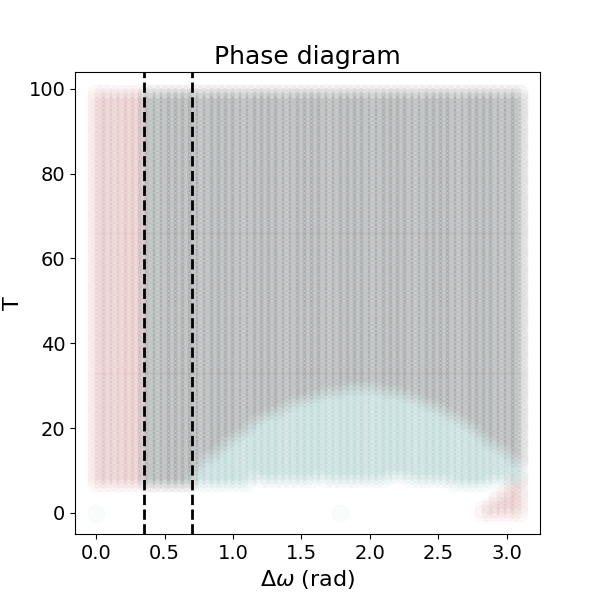

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Phase diagram', fontsize=18)
ax.set_ylabel('T', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 10)
# ax.set_xlim(0, np.pi)

ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.02, c='firebrick')
ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.02, c='teal')

# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()

---
---
---

---
---
---

In [16]:
# check if the solutions in comp make sense
# select one row of comp
row = comp.iloc[0]

# compute the energy of the solution
row

J12                                   1
J1                                   10
J2                                   10
T                                    10
om                 [1.0, 0.0, 1.0, 0.0]
theta0                         0.349066
phi1          [1.0462539829627164, 0.0]
phi2          [1.0462539829627164, 0.0]
is_sol                             True
is_stable                          True
om1                                 0.0
om2                                 0.0
omega_diff                          0.0
Name: 0, dtype: object

In [65]:
def free_energy(phi, T=10, J12=10, J1=10, J2=0, omega1x=np.cos(np.radians(10)), omega1y=np.sin(np.radians(10)), omega2x=np.cos(np.radians(0)), omega2y=np.sin(np.radians(0))):
    phi1x, phi1y, phi2x, phi2y = phi
    return T/J12 * (phi1x*phi2x + phi1y*phi2y) + J1*J2/(T*J12) * (omega1x*omega2x + omega1y*omega2y) - 1/J12 * (J2*phi1x*omega2x + J1*phi2x*omega1x + J2*phi1y*omega2y + J1*phi2y*omega1y)- np.log(i0(np.sqrt(phi1x**2 + phi1y**2))) - np.log(i0(np.sqrt(phi2x**2 + phi2y**2)))

T = 10
J12 = 10
J1 = 10
J2 = 10
om1 = np.radians(10)
om2 = 0

omega1x = np.cos(om1)
omega1y = np.sin(om1)
omega2x = np.cos(om2)
omega2y = np.sin(om2)

# minimize the free energy
# res = minimize(free_energy, x0=[10,10,10,10], args=(T, J12, J1, J2, omega1x, omega1y, omega2x, omega2y), method='Nelder-Mead', tol=1e-6)
res = basinhopping(free_energy, x0=[omega1x, omega1y, omega2x, omega2y], niter=1000)#, minimizer_kwargs={'method': 'Nelder-Mead'})

# check if res is really a minimum
res


                        fun: -331773.90310706425
 lowest_optimization_result:       fun: -331773.90310706425
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 528.6328125 ,   -8.94921875, -626.1875    ,   85.15625   ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 557
      nit: 0
     njev: 109
   status: 2
  success: False
        x: array([-624.20357541,   85.31684671,  527.63912218,   -8.81489144])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 1001
                       nfev: 562392
                        nit: 1000
                       njev: 110076
                    success: False
                          x: array([-624.20357541,   85.31684671,  527.63912218,   -8.81489144])

In [66]:
# minimize multivariate function

def free_energy(phi, T=10, J12=10, J1=10, J2=0, omega1x=np.cos(np.radians(10)), omega1y=np.sin(np.radians(10)), omega2x=np.cos(np.radians(0)), omega2y=np.sin(np.radians(0))):
    phi1x, phi1y, phi2x, phi2y = phi
    return T/J12 * (phi1x*phi2x + phi1y*phi2y) + J1*J2/(T*J12) * (omega1x*omega2x + omega1y*omega2y) - 1/J12 * (J2*phi1x*omega2x + J1*phi2x*omega1x + J2*phi1y*omega2y + J1*phi2y*omega1y)- np.log(i0(np.sqrt(phi1x**2 + phi1y**2))) - np.log(i0(np.sqrt(phi2x**2 + phi2y**2)))

T = 10
J12 = 10
J1 = 10
J2 = 10
om1 = np.radians(10)
om2 = 0

omega1x = np.cos(om1)
omega1y = np.sin(om1)
omega2x = np.cos(om2)
omega2y = np.sin(om2)

# minimize the free energy

res = minimize(free_energy, x0=[10,10,10,10], args=(T, J12, J1, J2, omega1x, omega1y, omega2x, omega2y), method='Nelder-Mead', tol=1e-6)
res

 final_simplex: (array([[ 215.4964101 , -714.96977799, -743.89554989,  180.93486435],
       [ 215.4964101 , -714.96977799, -743.89554989,  180.93486435],
       [ 215.4964101 , -714.96977799, -743.89554989,  180.93486435],
       [ 215.4964101 , -714.96977799, -743.89554989,  180.93486435],
       [ 215.4964101 , -714.96977799, -743.89554989,  180.93486435]]), array([-inf, -inf, -inf, -inf, -inf]))
           fun: -inf
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 158
        status: 1
       success: False
             x: array([ 215.4964101 , -714.96977799, -743.89554989,  180.93486435])

In [88]:
# first line of the dataframe
# print(df_comp.iloc[0])

T = df_comp.iloc[0]['T']
J12 = df_comp.iloc[0]['J12']
J1 = df_comp.iloc[0]['J1']
J2 = df_comp.iloc[0]['J2']
om = df_comp.iloc[0]['om']
phi1 = df_comp.iloc[0]['phi1']
phi2 = df_comp.iloc[0]['phi2']
print(np.degrees(phi1))
print(np.degrees(phi2))
# concatenate phi1 and phi2
phi = np.concatenate((phi1, phi2))


print(free_energy(phi, T, J12, J1, J2, om[0], om[1], om[2], om[3]))

# sligly change phi in all directions

phi_eps = phi - 0.005

print(free_energy(phi_eps, T, J12, J1, J2, om[0], om[1], om[2], om[3]))


[59.94593752  0.        ]
[59.94593752  0.        ]
-0.49247973248881693
-0.49199940496045746


J12                                   1
J1                                   10
J2                                   10
T                                    10
om                 [1.0, 0.0, 1.0, 0.0]
theta0                         0.349066
phi1          [1.0462539829627164, 0.0]
phi2          [1.0462539829627164, 0.0]
is_sol                             True
is_stable                          True
om1                                 0.0
om2                                 0.0
omega_diff                          0.0
Name: 0, dtype: object